## Last.fm Dataset

Version 1.2, Marzo 2010

Este dataset contiene usuarios, artistas y reproducciones para cerca de 360,000 usuario de Last.fm

Consta de dos archivos que contiene informacion de las reproducciones por artista por usuario e información de los usuarios

Puede descargarse directo de la siguiente liga: [Last.fm Dataset - 360K users](http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html)

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy import stats

from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
user_data = pd.read_table('lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv',
                          header=None,
                          names=['user', 'musicbrainz-artist-id', 'artist', 'plays'],
                          usecols=['user', 'artist', 'plays'])

Tenemos una fila por cada artista que ha reproducido un usuario y su numero total de reporducciones

In [3]:
user_data.head()

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


## Top 10 reproducciones por artista en last.fm

In [4]:
user_data.groupby('artist').plays.sum().reset_index(name='plays').sort_values('plays', ascending=False).head(10)

,artist,plays
252494,the beatles,30466827
217883,radiohead,27426234
73856,coldplay,16686772
212496,pink floyd,15943557
186241,metallica,15481852
194163,muse,15451683
199674,nine inch nails,14075619
220128,red hot chili peppers,13547741
171169,linkin park,12836638
247942,system of a down,11917336


In [5]:
user_profiles = pd.read_table('lastfm-dataset-360K/usersha1-profile.tsv',
                          header = None,
                          names = ['user', 'gender', 'age', 'country', 'signup'],
                          usecols = ['user', 'country','gender', 'age'])

In [6]:
## tenemos paises diferentes en last.fm
user_profiles.groupby('country')['user'].count()

country
Afghanistan           74
Albania               50
Algeria               40
American Samoa        22
Andorra              130
                    ... 
Wallis and Futuna     31
Western Sahara        27
Yemen                 15
Zambia                13
Zimbabwe              64
Name: user, Length: 239, dtype: int64

In [7]:
## total de usuarios en last.fm
user_profiles.groupby('country').count().user.sum()

359347

In [8]:
## total de ususarios por género
user_profiles.groupby('gender')['user'].count()

gender
f     84930
m    241642
Name: user, dtype: int64

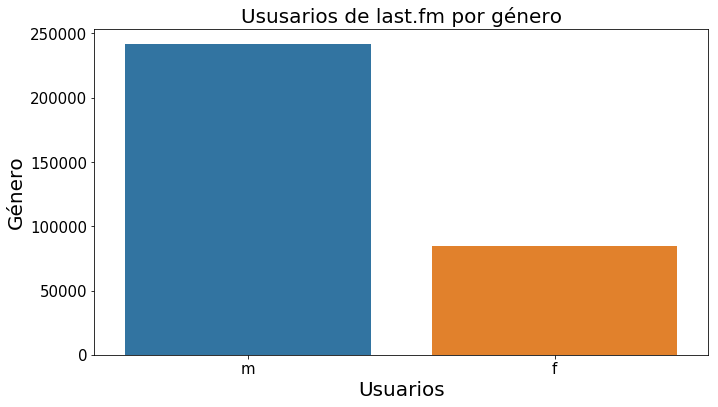

In [9]:
plt.figure(figsize = (11, 6))
sns.countplot(data=user_profiles,
              order=user_profiles.gender.value_counts().index,
              x ='gender')
plt.tick_params(labelsize = 15)
plt.title("Ususarios de last.fm por género", fontsize = 20)
plt.xlabel("Usuarios", fontsize = 20)
plt.ylabel("Género", fontsize = 20)
plt.show()

In [10]:
user_profiles.drop('gender', axis=1, inplace=True)

## Distribución de ususarios por edad

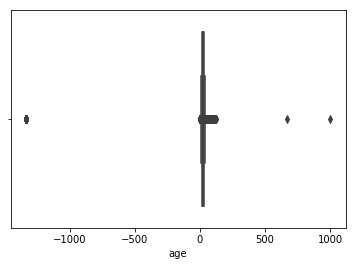

In [11]:
sns.boxplot(x=user_profiles.age)
plt.show()

In [12]:
user_profiles.age.describe()

count   284447.000
mean        25.098
std         21.666
min      -1337.000
25%         20.000
50%         23.000
75%         28.000
max       1002.000
Name: age, dtype: float64

### Removiendo los outliers de la columna de edad

Z-score es encontrar la distribución de datos donde la media es 0 y la desviación estándar es 1, es decir, distribución normal.

Mientras calculamos la Z-score, volvemos a escalar y centramos los datos y buscamos puntos de datos que estén demasiado lejos de cero. Estos puntos de datos que están demasiado lejos de cero se tratarán como valores atípicos. En la mayoría de los casos, se utiliza un umbral de 3 o -3, es decir, si el valor del Z-score es mayor o menor que 3 o -3 respectivamente, ese punto de datos se identificará como valores atípicos.

In [13]:
ages = user_profiles.age
ages.dropna(inplace=True)
z_scores = stats.zscore(ages)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
ages_clean = ages[filtered_entries]

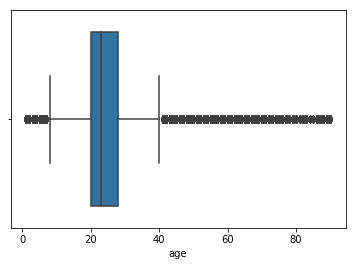

In [14]:
sns.boxplot(x=ages_clean)
plt.show()

In [15]:
ages_clean.describe()

count   282969.000
mean        24.967
std          7.829
min          1.000
25%         20.000
50%         23.000
75%         28.000
max         90.000
Name: age, dtype: float64

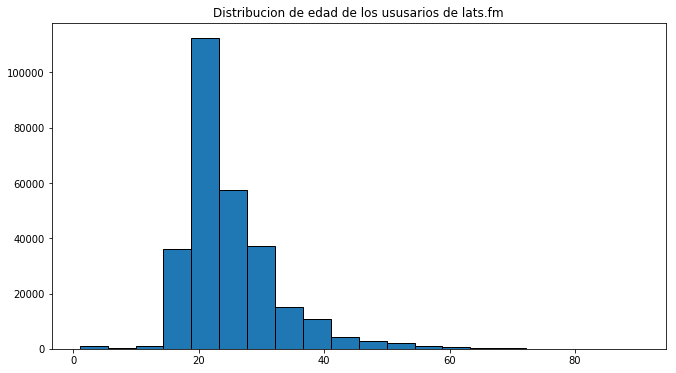

In [16]:
plt.figure(figsize = (11, 6))
ages_clean.hist(bins=20,  histtype='bar', ec='black')
plt.title("Distribucion de edad de los ususarios de lats.fm")
plt.grid(False)
plt.show()

In [17]:
user_profiles.drop('age', axis=1, inplace=True)

## Top 20 paises ususarios de last.fm

In [18]:
user_profiles.groupby('country').count().reset_index().sort_values('user', ascending=False).head(20)

,country,user
225,United States,67044
79,Germany,31651
224,United Kingdom,29902
170,Poland,20987
176,Russian Federation,19833
29,Brazil,14534
204,Sweden,13122
198,Spain,13051
71,Finland,11579
149,Netherlands,9650


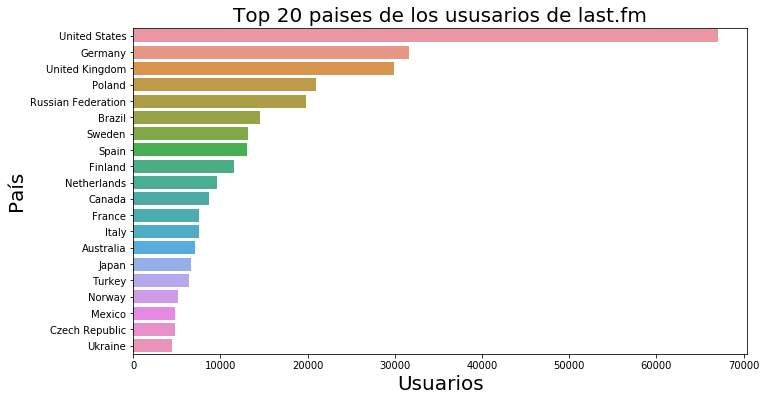

In [19]:
plt.figure(figsize = (11, 6))
sns.countplot(data=user_profiles,
              order=user_profiles.country.value_counts().iloc[:20].index,
              y='country')
plt.tick_params(labelsize = 10)
plt.title("Top 20 paises de los ususarios de last.fm", fontsize = 20)
plt.xlabel("Usuarios", fontsize = 20)
plt.ylabel("País", fontsize = 20)
plt.show()

In [20]:
## eleiminar artistas con nombres vacios
if user_data['artist'].isnull().sum() > 0:
    user_data = user_data.dropna(axis = 0, subset = ['artist'])

In [21]:
## agrupamos por artista y obtenemos sus numero de reproducciones
artist_plays = (user_data.
     groupby(by = ['artist'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_plays'})
     [['artist', 'total_plays']]
    )

In [22]:
artist_plays

,artist,total_plays
0,04)],6
1,2,1606
2,58725ab=>,23
3,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,70
4,amy winehouse,23
...,...,...
292358,￼antonio mairena,25
292359,￼beastie boys,85
292360,��|,369
292361,��疲暎�,142


In [23]:
artist_plays['total_plays'].describe()

count     292363.000
mean       12907.022
std       185981.631
min            1.000
25%           53.000
50%          208.000
75%         1048.000
max     30466827.000
Name: total_plays, dtype: float64

Tenemos casi 300 mil artistas distintos.

La mediana de las reproducciones por artista es de tan solo 200. Esto es un problema, ya que queremos recomendar a los mejores artistas.

In [24]:
artist_plays['total_plays'].quantile(np.arange(.9, 1, .01))

0.900     6137.800
0.910     7409.420
0.920     9102.040
0.930    11474.660
0.940    14898.000
0.950    19964.500
0.960    28420.120
0.970    43541.420
0.980    79403.560
0.990   198483.660
Name: total_plays, dtype: float64

Solo alrededor del 1% de los aritstas tienen cerca de 200 mil reproducciones, 2% tienen 80 mil o mas y 3% tienen 40 mil o más reproducciones
Para este ejercicio solo nos concentraremos en el top 3% de los artistas.

In [25]:
## juntamos ambos df
user_data_artist_plays = user_data.merge(artist_plays, on='artist', how = 'left')

In [26]:
## filtramos a los artistas con un minimo de 40000 reproducciones
top_artists = user_data_artist_plays[user_data_artist_plays['total_plays']>=40000]
top_artists.sort_values('total_plays',ascending=False)

,user,artist,plays,total_plays
14544183,d452ee05098069882421a2b4456c64021c3f130a,the beatles,204,30466827
6937382,65604cf9d1ba30dbbe6f9f9be9ea6972eb81effa,the beatles,53,30466827
5574504,5195681c3eabc0cb04c620b50164ba1670bc2d3a,the beatles,3202,30466827
595848,08b2d4d20eb86f6af1fbccb4e97e5e14e06d0bca,the beatles,118,30466827
13602355,c6bc9d3ff42f0db6bc3a73bb95dfca4bb42dfe7c,the beatles,116,30466827
...,...,...,...,...
3773421,374c41c1220251a45423c0d5fc3f53c40f85f37d,accessory,63,40005
2951613,2b1bf9f5db0cd8eaf21569a8ce58502ed57c82dc,accessory,495,40005
13555469,c60fe110dda47e1959a494da7d9b027fcdbec8cc,accessory,49,40005
6145345,59dcc7ad716af89dd7f6a25b75df68039b65f1e9,accessory,127,40005


In [27]:
## Unimos ambos df
combined = top_artists.merge(user_profiles, on='user', how= 'left')
## Filtramos por país, queremos ver a los usuarios de un país particular
country_data = combined[combined['country']=='Mexico']

In [44]:
## top 10 artististas reproducidos en mexico segun last.fm
country_data.groupby('artist').plays.sum().reset_index(name='plays').sort_values('plays', ascending=False).head(10)

,artist,plays
5348,radiohead,664288
6430,the beatles,559489
4635,muse,348023
1174,café tacuba,332901
5181,pink floyd,312931
4158,madonna,260018
1473,coldplay,256785
6670,the killers,247903
2416,fey,238450
876,björk,229696


In [29]:
## eliminamos ducplicados
if not country_data[country_data.duplicated(['user', 'artist'])].empty:
    initial_rows = country_data.shape[0]

In [30]:
## df con la lista completa de reprodcuciones
country_total_plays = country_data.groupby('artist').plays.sum().reset_index(name='plays').sort_values('plays', ascending=False)

Para K-vecinos más cercanos, queremos que los datos estén en una matriz m x n, donde m es el número de artistas y n es el número de usuarios.

In [31]:
## creamos nuestra matriz rala
wide_artist_data = country_data.pivot(index = 'artist', columns = 'user', values = 'plays').fillna(0)
## reset a los indices de la tabla para poder buscar un artista por indice
indexes = wide_artist_data.reset_index()
## convertimos cada valor a 0 o 1, se ha escuchado o no al artista
wide_artist_data_binary = wide_artist_data.apply(np.sign)
##nuestra matriz rala tiene esta forma: asrtistas x ususarios
wide_artist_data_binary.shape

(7623, 4828)

## Filtrado colaborativo

El enfoque de filtrado colaborativo crea un modelo a partir de los comportamientos pasados de un usuario (si ha escuchado o no a un artista), así como decisiones similares tomadas por otros usuarios. Este modelo es usado para predecir otros elementos (o calificaciones de elementos) en los que el usuario puede tener interés.

KNN es un método de aprendizaje no paramétrico. Utiliza una base de datos en la que los puntos de datos se separan en varios grupos para hacer inferencias para nuevas muestras.

KNN no hace ninguna suposición sobre la distribución subyacente de los datos. Cuando KNN hace inferencias sobre un artista, KNN calculará la "distancia" entre el artista destino y todos los demás artistas, luego clasifica sus distancias y devuelve los K artistas más cercanas como las recomendaciones de artistas similares

El desempeño de KNN sufrirá la maldición de la dimensionalidad si usa "distancia euclidiana" como su función objetivo. La distancia euclidiana no es útil en dimensiones altas porque todos los vectores son casi equidistantes al vector de consulta de búsqueda. En su lugar, usaremos la similitud coseno para la búsqueda del vecino más cercano.





In [32]:
## entrenamos el modelo con k vecinos cercanos y similaridad coseno
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(wide_artist_data_binary)

NearestNeighbors(metric='cosine')

In [42]:
## hacemos algunas recomendaciones basados en el index de un artista
index = 0
k = 10
print(f'Artist index : {index}')

distances, indices = model_knn.kneighbors(wide_artist_data_binary.iloc[index, :].values.reshape(1, -1), n_neighbors=k+1)
## aplanamos los resultados para poder iterar sobre ellos
indices = indices.flatten()
distances = distances.flatten()

print (f'Recommendations for: {wide_artist_data_binary.index[index]}')
print (f'Total plays in Mexico: {country_total_plays.loc[index][1]}\n')

for i in range(1,k+1):
    print (f'{i}: {wide_artist_data_binary.index[indices[i]]}\t distance: {round(distances[i],3)}')

Artist index : 0
Recommendations for: !!!
Total plays in Mexico: 6392

1: the presets	 distance: 0.822
2: hot chip	 distance: 0.849
3: zion i	 distance: 0.859
4: jimi tenor	 distance: 0.859
5: hilltop hoods	 distance: 0.859
6: heatmiser	 distance: 0.859
7: midnight juggernauts	 distance: 0.866
8: aesop rock	 distance: 0.866
9: cajun dance party	 distance: 0.866
10: digitalism	 distance: 0.868


In [34]:
def artist_recommendations(artist, k):
    try:
        g = nx.Graph()
        index = indexes[indexes['artist']==artist].index.values[0]
        print(f'Artist index : {index}')

        ## encontramos los indices y las distancias de los k vecinos mas cercanos
        distances, indices = model_knn.kneighbors(wide_artist_data_binary.iloc[index, :].values.reshape(1, -1), n_neighbors=k+1)
        ## aplanamos los resultados para poder iterar sobre ellos
        indices = indices.flatten()
        distances = distances.flatten()

        print (f'Recommendations for: {wide_artist_data_binary.index[index]}')
        print (f'Total plays in Mexico: {country_total_plays.loc[index][1]}\n')

        for i in range(1,k+1):
            print (f'{i}: {wide_artist_data_binary.index[indices[i]]}\t distance: {round(distances[i],3)}')
            g.add_edge(artist, wide_artist_data_binary.index[indices[i]], weight=distances[i] / i)
        print('\n')
        nx.draw(g, with_labels = True)
    except:
        print(f'{artist} not found in Mexico list')

Artist index : 4410
Recommendations for: metallica
Total plays in Mexico: 182254

1: iron maiden	 distance: 0.555
2: megadeth	 distance: 0.634
3: nirvana	 distance: 0.644
4: pantera	 distance: 0.649
5: ac/dc	 distance: 0.675
6: led zeppelin	 distance: 0.683
7: pink floyd	 distance: 0.688
8: pearl jam	 distance: 0.692
9: red hot chili peppers	 distance: 0.701
10: black sabbath	 distance: 0.703




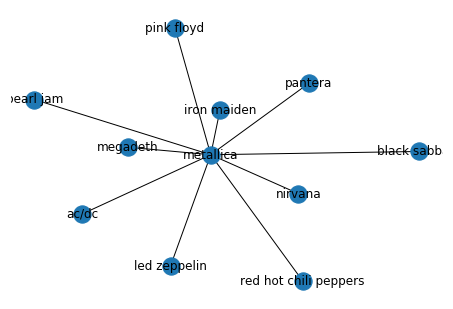

In [38]:
##podemos buscar recomendaciones para un artista por su nombre
artist_recommendations('metallica', k = 10)

## Referencias

* [K-neighborghs](https://scikit-learn.org/stable/modules/neighbors.html)
* [Collaborative Filtering](https://beckernick.github.io/datascience/)
* [Music Recommender with kNN](https://towardsdatascience.com/the-keys-building-collaborative-filtering-music-recommender-65ec3900d19f)
* [Recommender System with kNN](https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea)